In [1]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import shutil
import time
from collections import OrderedDict

import cc3d
import numpy as np
import pandas as pd
import wandb  # Import Wandb
import yaml
from scipy import integrate

# --- Competition Metric Functions (Copied from evaluation script) ---
from scipy.ndimage import distance_transform_edt
from src.eval_tools import (
    compute_multi_class_dsc,
    compute_multi_class_nsd,
    generate_clicks,
)
from src.viz_tools import plot_middle_slice, center_of_mass, save_volume_viz

from src.sammed3d import SAMMed3DPredictor
from surface_distance import (
    compute_dice_coefficient,
    compute_surface_dice_at_tolerance,
    compute_surface_distances,
)
from tqdm import tqdm


KeyboardInterrupt: 

In [ ]:
import yaml

config = yaml.safe_load(open("/nfs/norasys/notebooks/camaret/segfm3d_nora_team/config.yaml"))


In [ ]:
img_dir = os.path.join(config["VAL_DIR"], "3D_val_npz")
gt_dir = os.path.join(config["VAL_DIR"], "3D_val_gt_interactive_seg")
cases = sorted([f for f in os.listdir(img_dir) if f.endswith(".npz")])

In [ ]:
case_filename = cases[0]
case_name = os.path.splitext(case_filename)[0]
input_filepath = os.path.join(img_dir, case_filename)
gt_filepath = os.path.join(gt_dir, case_filename)

In [ ]:
data = np.load(input_filepath, allow_pickle=True)
gt_data = np.load(gt_filepath)
image = data["imgs"]
spacing = data["spacing"]
gts = gt_data["gts"]
print(image.shape)
initial_bbox = data.get("boxes", None)  # Use .get for optional keys


(63, 512, 512)
GT center of mass for CT_AMOS_amos_0018:
Center of mass coordinates (z, y, x): (41.16563162124644, 243.3364214217871, 374.5257251406444)
Initial bounding box for CT_AMOS_amos_0018, class 1: {'z_min': 32, 'z_max': 50, 'z_mid': 41, 'z_mid_x_min': 329, 'z_mid_y_min': 189, 'z_mid_x_max': 416, 'z_mid_y_max': 313}


In [ ]:
# occurences of each class in the gt
unique, counts = np.unique(gts, return_counts=True)
print("Unique classes and their counts in the GT:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} pixels")

np.argsort(counts)


In [ ]:
# pick the largest class : 6
class_id = 6
print(f"GT center of mass for {case_name}:")
print(f"Center of mass coordinates (z, y, x): {center_of_mass(gts==class_id)}")
if initial_bbox is not None:
    bbox = initial_bbox[class_id-1] # class 0 is not in the bbox list
    print(f"Initial bounding box for {case_name}: {bbox}")
    img_bbox = np.zeros_like(image)
    img_bbox[
        bbox['z_min'] : bbox['z_max'],
        bbox['z_mid_y_min'] : bbox['z_mid_y_max'],
        bbox['z_mid_x_min'] : bbox['z_mid_x_max'],
        
        
        
    ] = 1

GT center of mass for CT_AMOS_amos_0018:
Center of mass coordinates (z, y, x): (45.04110788794345, 287.70536887258754, 184.24973447173787)
Initial bounding box for CT_AMOS_amos_0018: {'z_min': 27, 'z_max': 57, 'z_mid': 46, 'z_mid_x_min': 96, 'z_mid_y_min': 171, 'z_mid_x_max': 340, 'z_mid_y_max': 384}


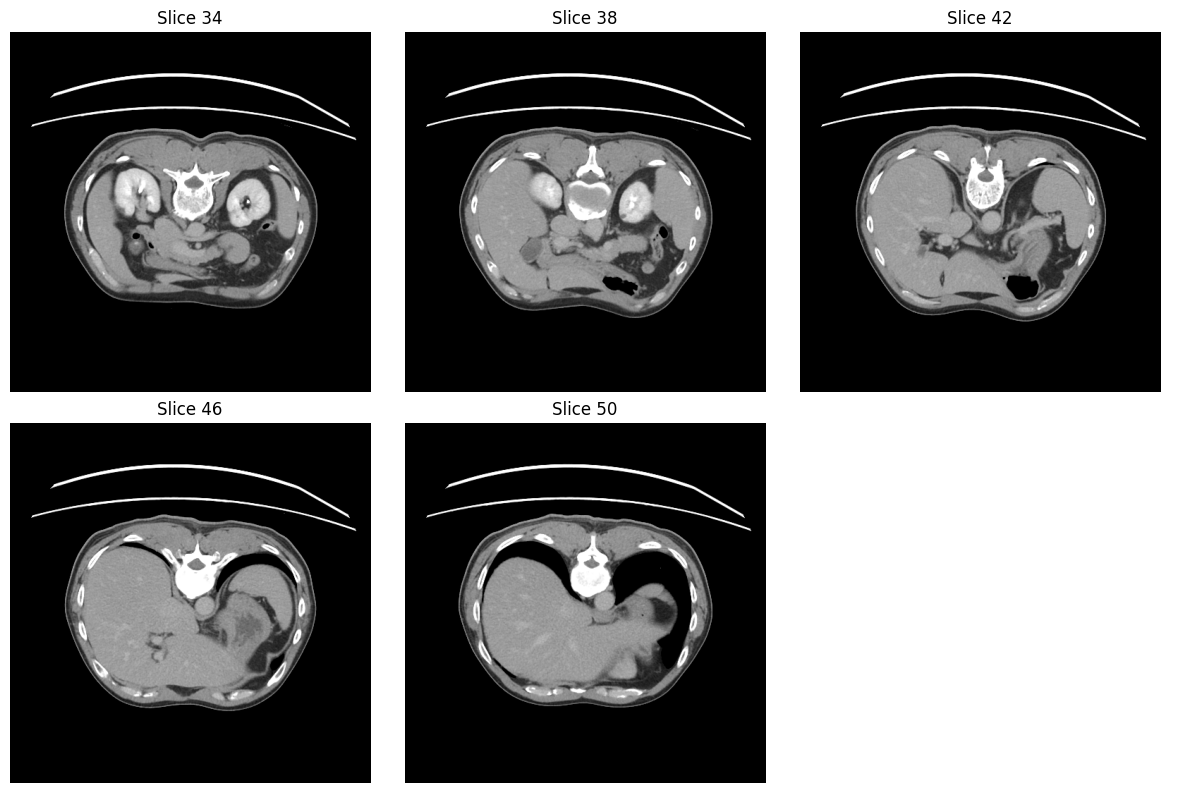

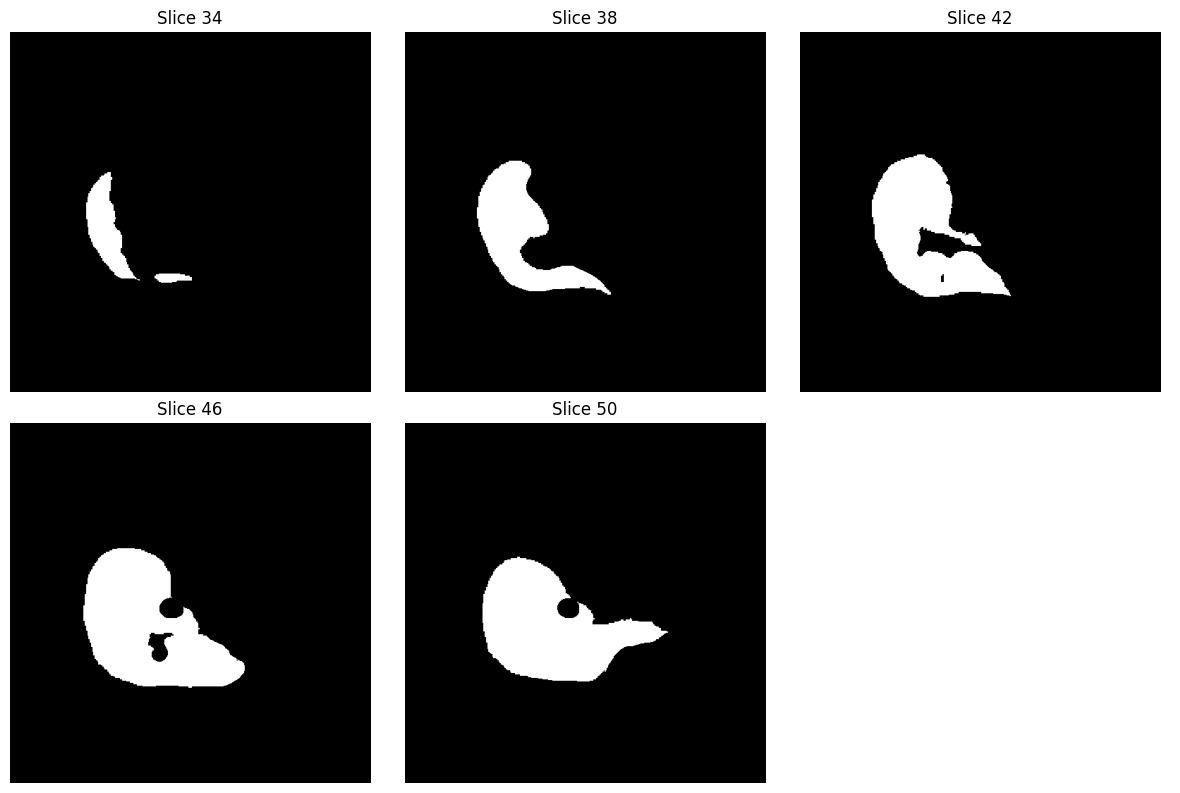

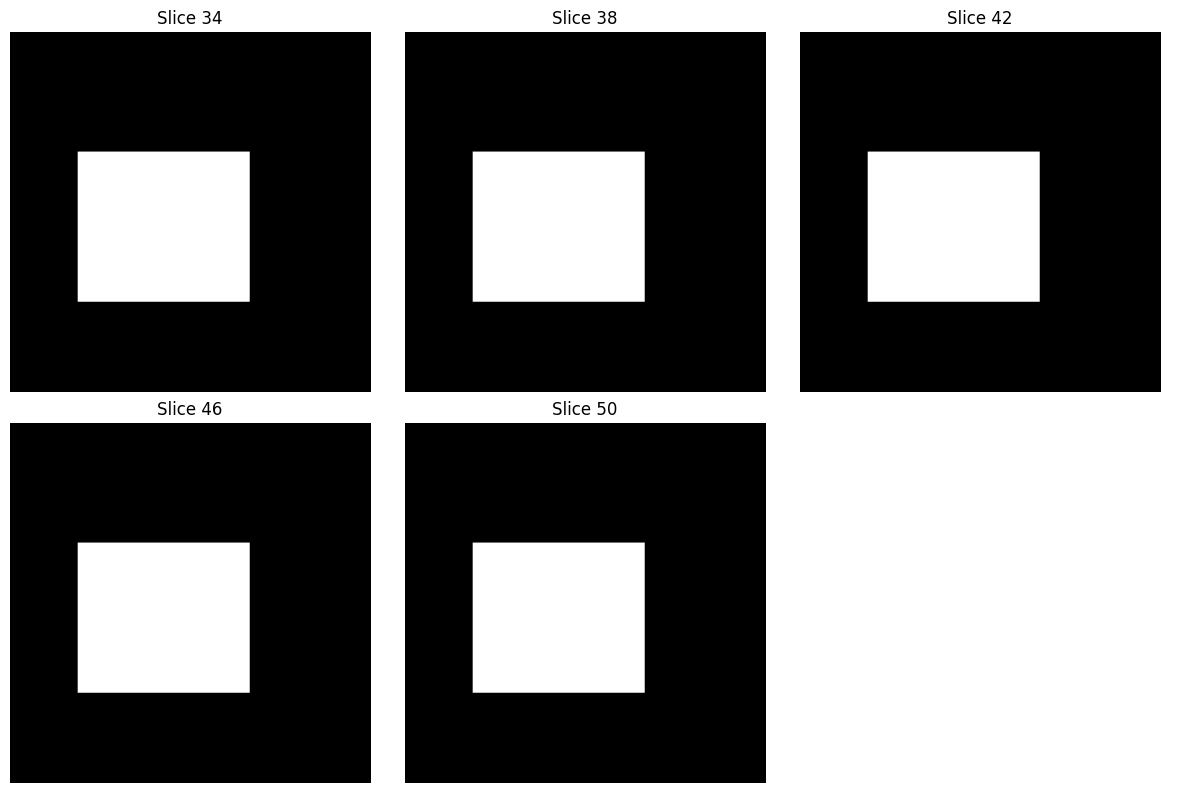

In [ ]:
save_volume_viz(image, slice_indices = list(range(34,51,4)), show=True)
save_volume_viz(gts==class_id, slice_indices = list(range(34,51,4)), show=True,) 
save_volume_viz(img_bbox, slice_indices = list(range(34,51,4)), show=True,) 


In [ ]:
predictor = SAMMed3DPredictor(checkpoint_path=config["SAM_CKPT_PATH"])

Initializing SAMMed3DPredictor with checkpoint: /nfs/norasys/notebooks/camaret/SAM-Med3D/ckpt/sam_med3d_turbo_bbox_cvpr.pth
   Using device: cuda
   Debug outputs will be saved to: sam_debug_output
creating model SAM-Med3D
SAMMed3DPredictor: Model loaded and set to eval mode.


In [ ]:
current_segmentation, infer_time = predictor.predict(
                    image_data=image,
                    spacing_data=spacing,
                    bbox_data=[bbox],
                    clicks_data=None,
                    prev_pred_data=None,  # Pass previous prediction
                    #num_classes_max=num_classes_max,
                )


--- SAMMed3DPredictor.predict() start (Debug Mode) | Case: unknown_case, Iter: -1 ---
   prev_pred_data is None, initializing as zeros.
   Mode: BBox, Classes Prompted: 1
   Processing up to 1 classes.

--- Processing Class Index: 1 ---
   Input cls_prev_seg_mask shape: (63, 512, 512), Sum: 0
   Copied previous prediction area for class 1 to initial output.
   Using BBox center as prompt point (ZYX?): (42.0, 277.5, 218.0)
   Prompt point determined: (42.0, 277.5, 218.0), is_positive: True
   Integer prompt point for create_gt_arr (ZYX): (42, 277, 218)
   Generated cls_gt shape: (63, 512, 512), Sum: 125.0, Unique values: [0. 1.]
   Saved unknown_case_iter-1_class1_1_cls_gt.npy
   Preprocessing...
     Input image_data shape: (63, 512, 512), dtype: uint8
     Input cls_gt shape: (63, 512, 512), dtype: float64, sum: 125.0
     Input cls_prev_seg_mask shape: (63, 512, 512), dtype: uint8
     Input spacing_data (XYZ?): [0.84600002 0.84600002 5.        ]
   Preprocessing done.
     roi_imag

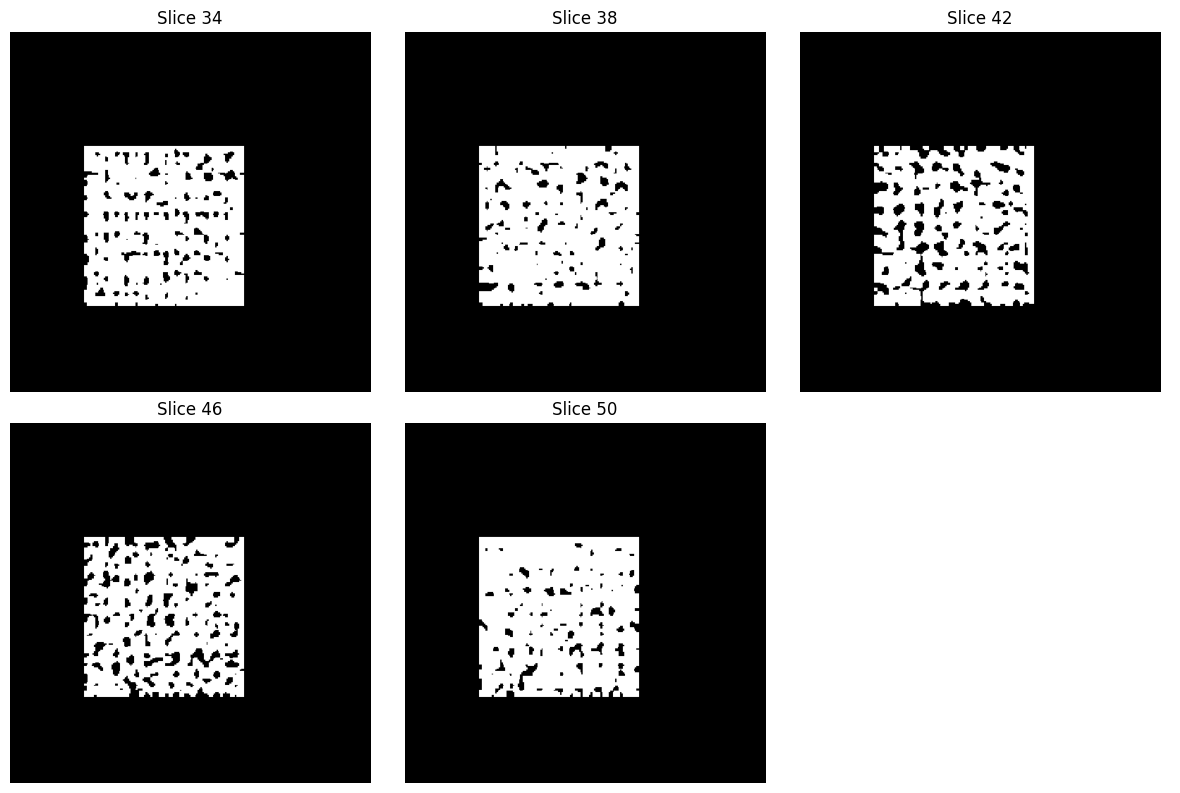

In [ ]:
current_segmentation.shape
save_volume_viz(current_segmentation, slice_indices = list(range(34,51,4)), show=True,) 
